<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal Nº6
## Revisión: 1
#### Tobías Guerrero

## 1. Introducción

En este trabajo semanal, se propone analizar el efecto y la eficiencia de distintas ventanas para realizar la estimación espectral de una señal.

Para esto, se propone generar una señal $x(k) = a_0 \cdot sen(\Omega_1 \cdot k)$, donde:
- $a_0 = 2$ 
- $\Omega_1 = \Omega_0 \cdot f_r \cdot \frac{2\pi}{N}$
- $\Omega_0 ? \frac{\pi}{2}$

La variable aleatoria $f_r$ estará definida por una distribución uniforme con límites $±2$. Se considerarán 200 realizaciones de la señal para dos casos de relación señal a ruido: 3 y 10dB.

A estas señales se le aplicarán tres ventanas distintas, para finalmente comparar los resultados obtenidos con cada una de ellas.

## 2. Resolución

In [1]:
# Librerías a utilizar
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
# Función para generar la señal, desarrollada en la TS1
def mifuncion( modo = "seno" , vmax = 1 , dc = 0 , ff = 1 , ph = 0 , nn = 1000 , fs = 1000 ):
    x = np.linspace(0 , (nn-1)/fs , nn) # Genero el array de tiempo
    if modo == "seno":
        y = dc + vmax * np.sin(2*np.pi*ff*x + ph) # Para generar la función senoidal utilizo la función provista por numpy
    elif modo == "cuadrada":
        y = dc + vmax * np.sign(np.sin(2*np.pi*ff*x + ph)) # Para generar una función cuadrada tomo el signo de la función seno
    elif modo == "diente":
        y = dc + 2 * vmax * (x * ff%1) - vmax # Para generar una función diente de sierra utilizo la fórmula de la recta que la representa. Al eje x lo escalo por la frecuencia para que se repita las veces que corresponda
    elif modo == "triangular":
        y = dc + 2 * vmax * (1 - np.abs((x * ff%1) - 0.5) * 2) - vmax ## Para generar una función triangular utilizo la fórmula que la representa. Al eje x lo escalo por la frecuencia para que se repita las veces que corresponda
    return x,y

In [3]:
# Variables para la generación de la señal
modo = "seno"
nn = 1000
fs = nn

### 2.1 Generación de las señales para SNRs de 3 y 10dB

In [4]:
omega = nn / 4
a = 2
realizaciones = 200
snr1 = 10 # dB

# Cálculo de la potencia de ruido a partir de la SNR
Ps = (a**2) / 2
Pr = Ps / 10**(snr1/10)

# Se genera una matriz de 200 vectores de 1000 muestras
s1 = np.zeros((realizaciones,nn))

In [5]:
# Bucle para generar las 200 realizaciones
for i in range(realizaciones):
    fr = np.random.uniform(-0.5 , 0.5) * fs / nn
    t , sr = mifuncion( modo = modo , vmax = a , ff = omega + fr , nn = nn , fs = fs )
    r = np.random.normal(0, Pr, nn)
    s1[i] = sr + r

In [6]:
# Se repite el proceso para una SNR = 3dB
snr2 = 3 # dB

Pr = Ps / 10**(snr2/10)

s2 = np.zeros((realizaciones,nn))

for i in range(realizaciones):
    fr = np.random.uniform(-0.5 , 0.5) * fs / nn
    t , sr = mifuncion( modo = modo , vmax = a , ff = omega + fr , nn = nn , fs = fs )
    r = np.random.normal(0, Pr, nn)
    s2[i] = sr + r

### 2.2 Ventana Rectangular

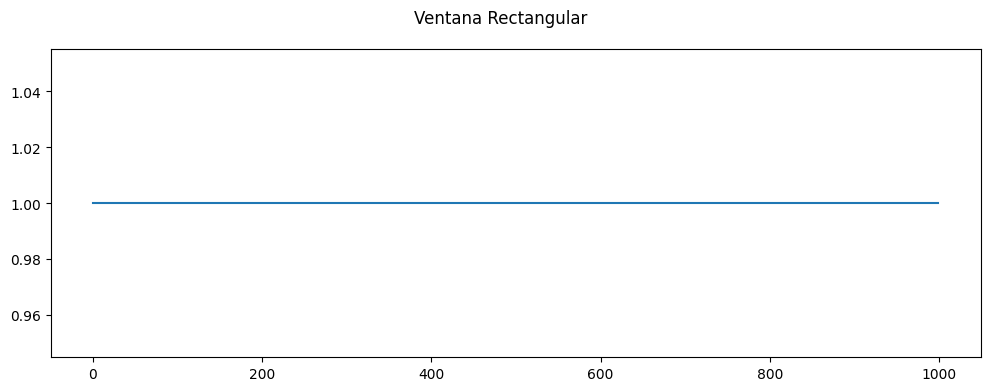

C:\Users\tobia\AppData\Local\Temp\ipykernel_10652\41113194.py:15: RuntimeWarning: divide by zero encountered in log10
  rect_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))


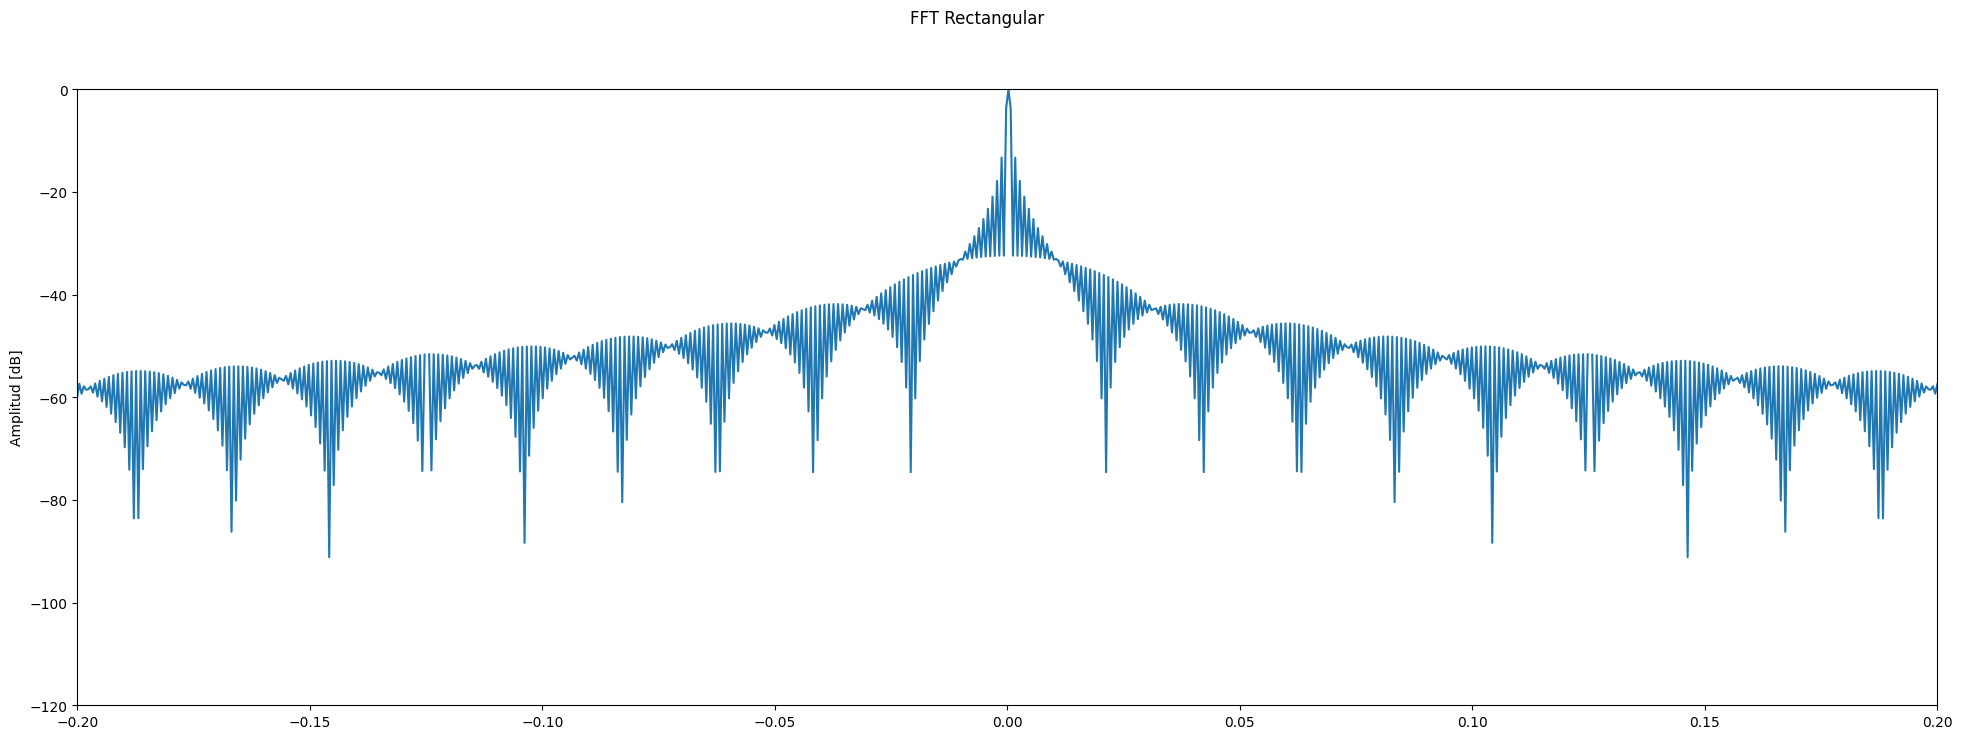

In [7]:
rectangular = sp.signal.windows.boxcar(nn) # Rectangular

fig_hist, axs_hist = plt.subplots(1, 1, figsize=(12, 4), sharex=True, sharey=True)
axs_hist.plot(rectangular)
fig_hist.suptitle("Ventana Rectangular")
plt.show()

# Ploteo de la FFT de las ventanas
fig_fft, axs_fft = plt.subplots(1, 1, figsize=(24, 8), sharex=True, sharey=True)

# De la documentacion de scipy.signal.windows:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.blackmanharris.html#scipy.signal.windows.blackmanharris
A = sp.fft.fft(rectangular, 2048) / (len(rectangular) / 2.0)
freq = np.linspace(-0.5, 0.5, len(A))
rect_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))

axs_fft.plot(freq, rect_dB)
axs_fft.set_ylim([-120, 0])
axs_fft.set_xlim([-0.2, 0.2])

axs_fft.set_ylabel("Amplitud [dB]")
plt.suptitle("FFT Rectangular")
plt.show()

In [8]:
S10dB_rec = np.fft.fft(s1*rectangular) / nn
S3dB_rec = np.fft.fft(s2*rectangular) / nn

#### 2.2.1. Cálculo de sesgo y varianza

In [10]:
a10dB_rec = np.abs(S10dB_rec[: , nn//4]) 
a3dB_rec = np.abs(S3dB_rec[: , nn//4]) 

a10dB_est_rec = np.mean(np.abs(S10dB_rec[: , nn//4])) # Media para SNR = 10dB
a3dB_est_rec = np.mean(np.abs(S3dB_rec[: , nn//4])) # Media para SNR = 3dB

sesgo10dB_rec = a10dB_est_rec - a
sesgo3dB_rec = a3dB_est_rec - a
#print(sesgo_1)
#print(sesgo_2)

var10dB_rec = np.sum((np.abs(S10dB_rec[: , nn//4]) - a10dB_est_rec)**2) / nn # Varianza para SNR = 10dB
var3dB_rec = np.sum((np.abs(S3dB_rec[: , nn//4]) - a3dB_est_rec)**2) / nn # Varianza para SNR = 3dB
print(var10dB_rec)
print(var3dB_rec)

0.002436162395680676
0.002877968142173537


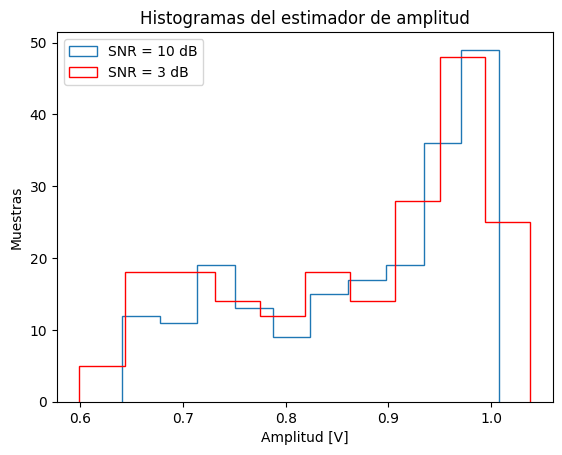

In [12]:
# Gráficos
plt.figure()
plt.title("Histogramas del estimador de amplitud")
plt.xlabel("Amplitud [V]")
plt.ylabel("Muestras")
plt.hist(a10dB_rec, bins = 10, histtype = 'step',label = 'SNR = 10 dB')
plt.hist(a3dB_rec, bins = 10, histtype = 'step',color = 'red',label = 'SNR = 3 dB')
plt.legend(loc='upper left')

### 2.3 Ventana Bartlett

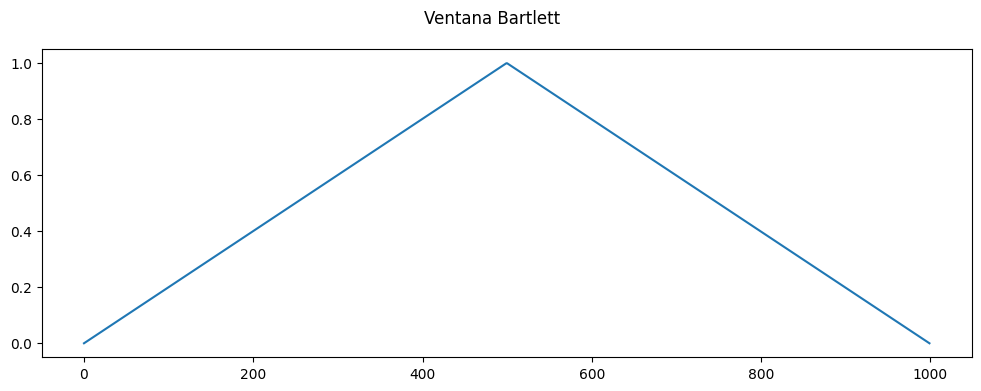

C:\Users\tobia\AppData\Local\Temp\ipykernel_10652\3503523276.py:15: RuntimeWarning: divide by zero encountered in log10
  bart_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))


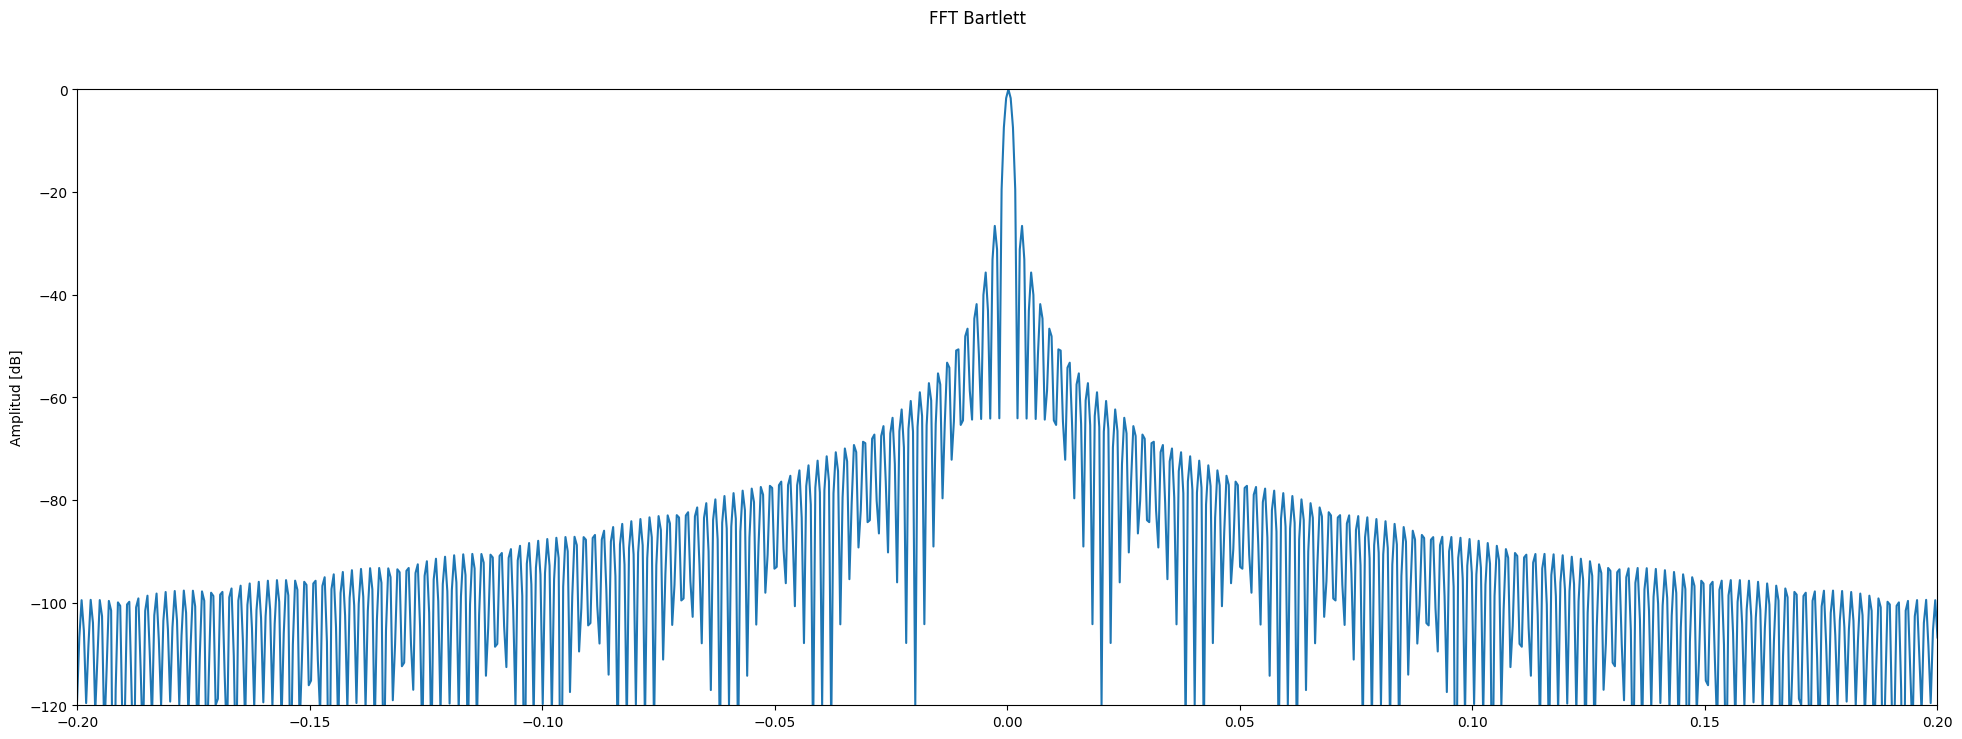

In [14]:
bartlett = sp.signal.windows.bartlett(nn) # Rectangular

fig_hist, axs_hist = plt.subplots(1, 1, figsize=(12, 4), sharex=True, sharey=True)
axs_hist.plot(bartlett)
fig_hist.suptitle("Ventana Bartlett")
plt.show()

# Ploteo de la FFT de las ventanas
fig_fft, axs_fft = plt.subplots(1, 1, figsize=(24, 8), sharex=True, sharey=True)

# De la documentacion de scipy.signal.windows:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.blackmanharris.html#scipy.signal.windows.blackmanharris
A = sp.fft.fft(bartlett, 2048) / (len(bartlett) / 2.0)
freq = np.linspace(-0.5, 0.5, len(A))
bart_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))

axs_fft.plot(freq, bart_dB)
axs_fft.set_ylim([-120, 0])
axs_fft.set_xlim([-0.2, 0.2])

axs_fft.set_ylabel("Amplitud [dB]")
plt.suptitle("FFT Bartlett")
plt.show()

#### 2.3.1. Cálculo de sesgo y varianza

0.0001621085286387859
0.00021831438927625703


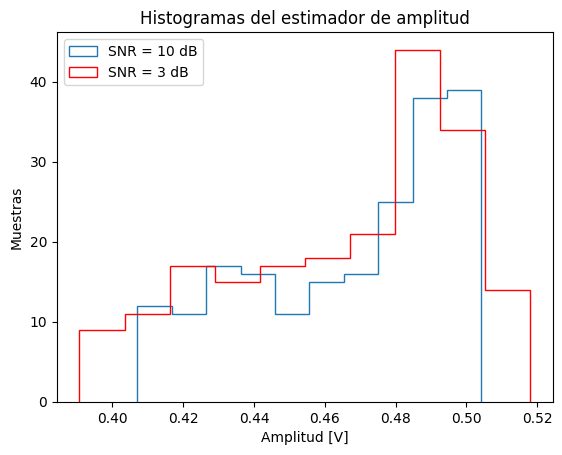

In [15]:
S10dB_bar = np.fft.fft(s1*bartlett) / nn
S3dB_bar = np.fft.fft(s2*bartlett) / nn

a10dB_bar = np.abs(S10dB_bar[: , nn//4]) 
a3dB_bar = np.abs(S3dB_bar[: , nn//4]) 

a10dB_est_bar = np.mean(np.abs(S10dB_bar[: , nn//4])) # Media para SNR = 10dB
a3dB_est_bar = np.mean(np.abs(S3dB_bar[: , nn//4])) # Media para SNR = 3dB

sesgo10dB_bar = a10dB_est_bar - a
sesgo3dB_bar = a3dB_est_bar - a
#print(sesgo_1)
#print(sesgo_2)

var10dB_bar = np.sum((np.abs(S10dB_bar[: , nn//4]) - a10dB_est_bar)**2) / nn # Varianza para SNR = 10dB
var3dB_bar = np.sum((np.abs(S3dB_bar[: , nn//4]) - a3dB_est_bar)**2) / nn # Varianza para SNR = 3dB
print(var10dB_bar)
print(var3dB_bar)

# Gráficos
plt.figure()
plt.title("Histogramas del estimador de amplitud")
plt.xlabel("Amplitud [V]")
plt.ylabel("Muestras")
plt.hist(a10dB_bar, bins = 10, histtype = 'step',label = 'SNR = 10 dB')
plt.hist(a3dB_bar, bins = 10, histtype = 'step',color = 'red',label = 'SNR = 3 dB')
plt.legend(loc='upper left')

### 2.4 Ventana Blackman

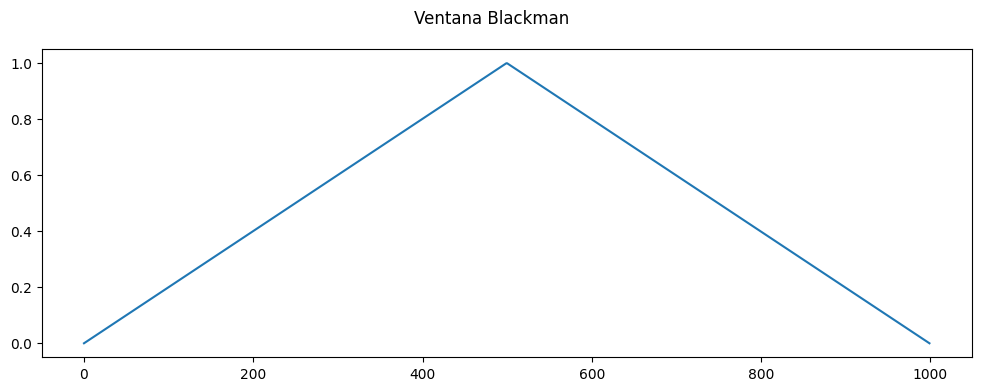

C:\Users\tobia\AppData\Local\Temp\ipykernel_10652\3921955074.py:15: RuntimeWarning: divide by zero encountered in log10
  black_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))


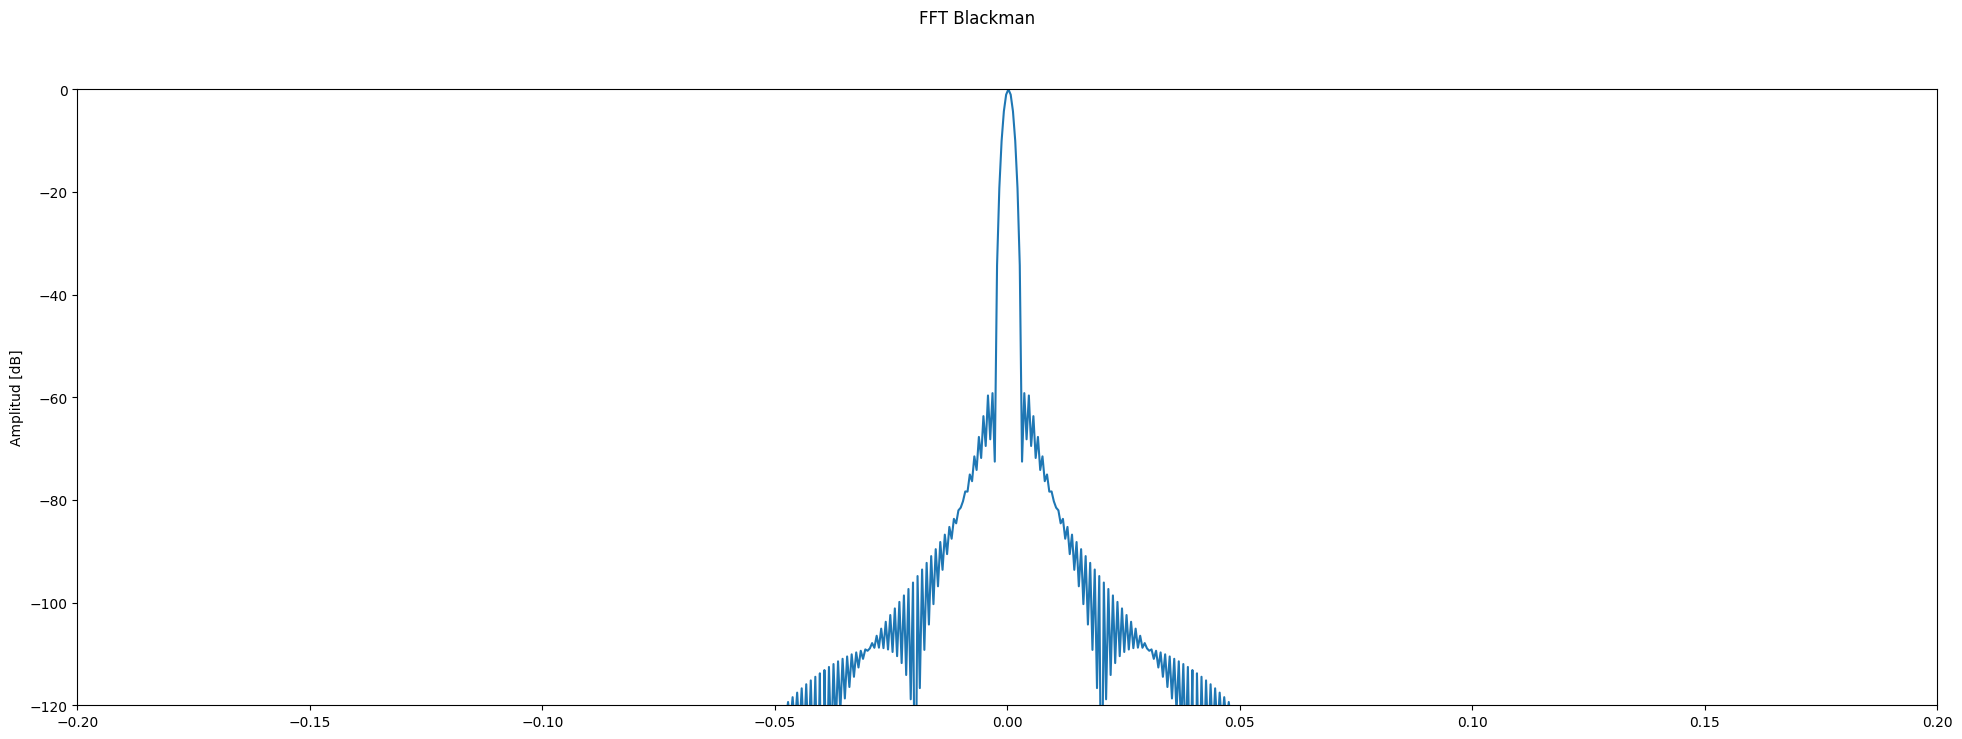

In [17]:
blackman = sp.signal.windows.blackman(nn) # Rectangular

fig_hist, axs_hist = plt.subplots(1, 1, figsize=(12, 4), sharex=True, sharey=True)
axs_hist.plot(bartlett)
fig_hist.suptitle("Ventana Blackman")
plt.show()

# Ploteo de la FFT de las ventanas
fig_fft, axs_fft = plt.subplots(1, 1, figsize=(24, 8), sharex=True, sharey=True)

# De la documentacion de scipy.signal.windows:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.blackmanharris.html#scipy.signal.windows.blackmanharris
A = sp.fft.fft(blackman, 2048) / (len(blackman) / 2.0)
freq = np.linspace(-0.5, 0.5, len(A))
black_dB = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A))))

axs_fft.plot(freq, black_dB)
axs_fft.set_ylim([-120, 0])
axs_fft.set_xlim([-0.2, 0.2])

axs_fft.set_ylabel("Amplitud [dB]")
plt.suptitle("FFT Blackman")
plt.show()

#### 2.4.1. Cálculo de sesgo y varianza

4.488981061341354e-05
8.215064638416171e-05


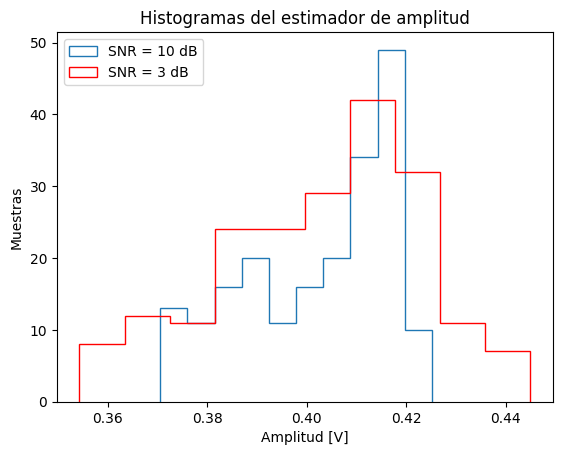

In [19]:
S10dB_bla = np.fft.fft(s1*blackman) / nn
S3dB_bla = np.fft.fft(s2*blackman) / nn

a10dB_bla = np.abs(S10dB_bla[: , nn//4]) 
a3dB_bla = np.abs(S3dB_bla[: , nn//4]) 

a10dB_est_bla = np.mean(np.abs(S10dB_bla[: , nn//4])) # Media para SNR = 10dB
a3dB_est_bla = np.mean(np.abs(S3dB_bla[: , nn//4])) # Media para SNR = 3dB

sesgo10dB_bla = a10dB_est_bla - a
sesgo3dB_bla = a3dB_est_bla - a
#print(sesgo_1)
#print(sesgo_2)

var10dB_bla = np.sum((np.abs(S10dB_bla[: , nn//4]) - a10dB_est_bla)**2) / nn # Varianza para SNR = 10dB
var3dB_bla = np.sum((np.abs(S3dB_bla[: , nn//4]) - a3dB_est_bla)**2) / nn # Varianza para SNR = 3dB
print(var10dB_bla)
print(var3dB_bla)


# Gráficos
plt.figure()
plt.title("Histogramas del estimador de amplitud")
plt.xlabel("Amplitud [V]")
plt.ylabel("Muestras")
plt.hist(a10dB_bla, bins = 10, histtype = 'step',label = 'SNR = 10 dB')
plt.hist(a3dB_bla, bins = 10, histtype = 'step',color = 'red',label = 'SNR = 3 dB')
plt.legend(loc='upper left')

### 2.5 Comparación de resultados

In [27]:
# Módulo para tabular
from tabulate import tabulate
 
head = ["Ventana", "Sesgo" , "Varianza"]

res10dB = [ 
    ["Rectangular", sesgo10dB_rec , var10dB_rec], 
    ["Bartlett", sesgo10dB_bar , var10dB_bar], 
    ["Blackmann", sesgo10dB_bla , var10dB_bla]
]
 
print("Resulados para SNR = 10dB")
print(tabulate(res10dB, headers=head, tablefmt="grid"))

res3dB = [ 
    ["Rectangular", sesgo3dB_rec , var3dB_rec], 
    ["Bartlett", sesgo3dB_bar , var3dB_bar], 
    ["Blackmann", sesgo3dB_bla , var3dB_bla]
]
 
print("\n\n Resulados para SNR = 3dB")
print(tabulate(res3dB, headers=head, tablefmt="grid"))

Resulados para SNR = 10dB
+-------------+----------+-------------+
| Ventana     |    Sesgo |    Varianza |
+=============+==========+=============+
| Rectangular | -1.12666 | 0.00243616  |
+-------------+----------+-------------+
| Bartlett    | -1.53294 | 0.000162109 |
+-------------+----------+-------------+
| Blackmann   | -1.59742 | 4.48898e-05 |
+-------------+----------+-------------+


 Resulados para SNR = 3dB
+-------------+----------+-------------+
| Ventana     |    Sesgo |    Varianza |
+=============+==========+=============+
| Rectangular | -1.13216 | 0.00287797  |
+-------------+----------+-------------+
| Bartlett    | -1.53394 | 0.000218314 |
+-------------+----------+-------------+
| Blackmann   | -1.5975  | 8.21506e-05 |
+-------------+----------+-------------+


## 3. Conclusiones

En primer lugar, se puede afirmar que a mayores relaciones señal a ruido, se obtienen mejores resultados en ambos ensayos, esto es, menores sesgos y varianzas (en módulo). Esta diferencia es menor en el caso del sesgo que en el de la varianza.

Se observa un sesgo relativamente grande en las tres ventanas, siendo la de mayor sesgo (en módulo) la de Blackmann, seguida por la de Bartlett y por último la rectangular. Esto se cumple para ambas SNR. Siendo el sesgo un error sistemático y pudiendo corregirse, no se considera que esto sea un error insalvable.

En cambio, el orden de mayor a menor en lo que respecta a la varianza es el inverso, siendo la rectangular la de mayor varianza y la de Blackmann la de menor, también para ambas SNR. Siendo que la varianza no es corregible, se considera este un valor más crítico. En función de esto, para lo que se desea ensayar, se puede afirmar que la ventana más efectiva es la de Blackmann.